# Train Sklearn Models With Simple Pipeline

In this notebook we train [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) and [Huber classifier](https://en.wikipedia.org/wiki/Huber_loss#Variant_for_classification) from sklearn library using the same pipeline and compare their perfomance.

In [1]:
import sys

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append('../..')

import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

from batchflow.models import SklearnModel
from batchflow.opensets import MNIST
from batchflow import B, C, V, D, Pipeline
from batchflow.utils import plot_images

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

# Create dataset

Load MNIST dataset.

In [2]:
dataset = MNIST()

# Initialize models

Provide the pipeline configs for each of the models.    
It has to contain the following keys:
* `model_name` 
* `estimator`  that has to be [SGDClassifiers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.predict_proba) instance.

In [3]:
huber_config = {'model_name': 'huber_model', 
                'estimator': SGDClassifier(loss='modified_huber')}

log_config = {'model_name': 'log_model', 
              'estimator': SGDClassifier(loss='log')}

Initialize both models with the estimators from the corresponding config keys, i.e. `config['estimator']`.

In [5]:
init_huber_model = Pipeline().init_model('dynamic', SklearnModel, 'huber_model', 
                                 config={'estimator' : C('estimator')})
init_log_model = Pipeline().init_model('dynamic', SklearnModel, 'log_model', 
                                 config={'estimator' : C('estimator')})

# Create train pipelines

Training pipeline template. We exploit the exact same pipeline various times with different estimators.

Pipeline preprocessing image actions include:
1. Transform images from `PIL.Image` to `np.array`.   
2. Reshape images to `2-dimensional` arrays where the number of rows equal to the batch size.

`Sklearn` models with `partial_fit` attribute support batch wise training and can be integrated into pipeline.

In [6]:
train_template = (dataset.train.p
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .train_model(C('model_name'), B.images, B.labels, 
                                classes=range(dataset.num_classes))
                    .run_later(64, n_iters=5000, drop_last=True, shuffle=True, bar=True)
                 ) 

Tie the pipeline's configs to the `train_template`    
Now we have ready to use training pipelines for each model.

In [7]:
huber_train_pipeline = (init_huber_model + train_template) << huber_config
log_train_pipeline = (init_log_model + train_template) << log_config

# Train the models

Run the pipelines.

In [8]:
huber_train_pipeline.run()

100%|██████████| 5000/5000 [02:40<00:00, 31.11it/s]


In [9]:
log_train_pipeline.run()

100%|██████████| 5000/5000 [02:33<00:00, 32.62it/s]


# Test the models

Import trained models from training pipelines.

In [10]:
import_huber_model = Pipeline().import_model('huber_model', huber_train_pipeline)
import_log_model = Pipeline().import_model('log_model', log_train_pipeline)

The same steps of preprocessing images used in test pipelines.   

In [11]:
test_template = (dataset.test.p
                    .init_variable('metrics')
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .predict_model(C('model_name'), B('images'),
                                   save_to=B('predictions'), proba=True)              
                    .gather_metrics('class', B('labels'), B('predictions'), num_classes=dataset.num_classes,
                                     fmt='proba', axis=1, save_to=V('metrics', mode='a'))
                    .run_later(200, n_epochs=1, drop_last=False, shuffle=True, bar=True)
                    .reshape(B('images'), (B('size'), 28, 28), save_to=B('images'))
                ) 

Tie the pipeline configs to the test template.

In [12]:
huber_test_pipeline = (import_huber_model + test_template) << huber_config
log_test_pipeline = (import_log_model + test_template) << log_config

Run test pipelines.

In [13]:
huber_test_pipeline.run()

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


In [14]:
log_test_pipeline.run()

100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Let's get the accumulated [metrics information](https://analysiscenter.github.io/batchflow/intro/models.html#model-metrics).

In [16]:
log_metrics = log_test_pipeline.v('metrics')
huber_metrics = huber_test_pipeline.v('metrics')

Calculate accuracy for both classifiers.

In [17]:
acc = [log_metrics.evaluate('acc'), huber_metrics.evaluate('acc')]

Logistic Regresion classifier outperfoms Huber classifier.

In [18]:
print('log_reg accuracy - {0} \nhuber accuracy - {1}'.format(*acc)) 

log_reg accuracy - 0.8473 
huber accuracy - 0.7691000000000001


Generate and pass the batch of images through the trained classifiers and look in more details at the predictions of each of them.   

In [19]:
huber_batch = huber_test_pipeline.next_batch(10, shuffle=42)
log_batch = log_test_pipeline.next_batch(10, shuffle=42)

Let's take a look at the predictions.

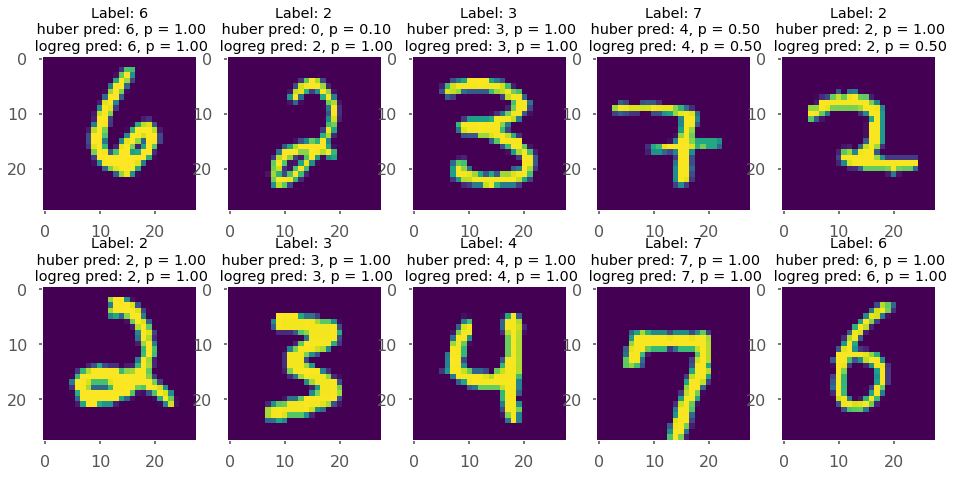

In [20]:
predictions = [huber_batch.predictions, log_batch.predictions]
plot_images(log_batch.images, log_batch.labels, predictions,
                        classes=None, figsize=(16, 12), models_names=['huber', 'logreg'])

# Conclusion

In this tutorial you have learnt how to train and validate `logistic regression` and `huber` classifier from [sklearn](https://scikit-learn.org/stable/index.html) library using [batchflow pipeline](https://analysiscenter.github.io/batchflow/intro/pipeline.html) functionality

In your futher research you can train [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) classifier or try to add more regularization to the models via passing `alpha` and `l1` arrguments to the `SGDClassifiers` instances.